<a href="https://colab.research.google.com/github/giumanuz/AoC22/blob/main/TESI_SATELLITI_FINALE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr
from skimage import io
from torchvision.transforms.functional import InterpolationMode


import os
import numpy as np
import random

from scipy.ndimage import zoom
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint

import random

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

print('IMPORTS OK')

IMPORTS OK


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Global Variables' Definitions

PATH_TO_DATASET_IMAGES = '/content/drive/MyDrive/Start'
PATH_TO_DATASET_LABELS = '/content/drive/MyDrive/Finish'

PATH_TO_TRAIN_DATASET_IMAGES = '/content/drive/MyDrive/Dataset2/train/images'
PATH_TO_TRAIN_DATASET_LABEL = '/content/drive/MyDrive/Dataset2/train/ground_truth'

PATH_TO_VAL_DATASET_IMAGES = '/content/drive/MyDrive/Dataset2/val/images'
PATH_TO_VAL_DATASET_LABEL = '/content/drive/MyDrive/Dataset2/val/ground_truth'

PATH_TO_TEST_DATASET_IMAGES = '/content/drive/MyDrive/Dataset2/test/images'
PATH_TO_TEST_DATASET_LABEL = '/content/drive/MyDrive/Dataset2/test/ground_truth'

BATCH_SIZE = 64
PATCH_SIDE = 96
N_EPOCHS = 500

NORMALISE_IMGS = True

LOAD_TRAINED = False

DATA_AUG = False


print('DEFINITIONS OK')

DEFINITIONS OK


In [ ]:
def get_tif_images(tif_path):
    images = []
    for filename in os.listdir(tif_path):
        if filename.endswith('.tif'):
            images.append(filename)
    return images

# print(get_tif_images(PATH_TO_DATASET))


class MyDataset(Dataset):
    """
    Custom class to load the dataset
    """
    def __init__(self, img_path, label_path, transform=None, allDataset=False):
        """
        Args:
            tif_path (string): path to tif files
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # read tif files from tif_path directory
        self.transform = transform
        print(transform)
        self.names = get_tif_images(img_path)
        self.color_map = {  (0, 0, 1): 0,
                            (0, 1, 1): 1,
                            (0, 1, 0): 2,
                            (1, 1, 1): 3,
                            (1, 1, 0): 4,
                            (1, 0, 0): 5}

        self.reverse_color_map = {0: (0, 0, 1),
                                    1: (0, 1, 1),
                                    2: (0, 1, 0),
                                    3: (1, 1, 1),
                                    4: (1, 1, 0),
                                    5: (1, 0, 0)}

        self.allDataset=allDataset



        self.data = torch.zeros(len(self.names)*len(transform), 3, PATCH_SIDE, PATCH_SIDE)
        self.labels = torch.zeros(len(self.names)*len(transform), 1, PATCH_SIDE, PATCH_SIDE, dtype=torch.long)

        for idx_transform, transform_element in enumerate(self.transform):
            for idx, name in enumerate(self.names):
                idx += len(self.names) * idx_transform
                img_name = os.path.join(img_path, name)
                image = io.imread(img_name)
                if allDataset:
                    label_name = os.path.join(label_path, name[:-9] + '_label.tif')
                else:
                  label_name = os.path.join(label_path, self.modify_string(name))
                label = io.imread(label_name)
                if self.transform:
                    image = transform_element(image)
                    label = transform_element(label)

                # print name of the image and its shape
                print('Image name: {} \t'.format(name))
                label = self.convert_image(label)
                self.data[idx] = image
                self.labels[idx] = label

    def modify_string(self, input_str):
      parts = input_str.split("_")
      parts.remove('IRRG')
      parts.insert(-1, "label")
      return "_".join(parts)

    def __len__(self):
        return len(self.data)

    def convert_image(self, tensor):
        """
        Convert tensor from 3 channel to one channel, and associate it a number from 0 to 5
        """
        converted_tensor = torch.zeros(1, tensor.size(1), tensor.size(2), dtype=torch.long)

        for x in range(tensor.size(1)):
            for y in range(tensor.size(2)):
                pixel_value = tensor[:, x, y]
                # apply treshold to pixel value for each channel
                for i in range(3):
                    if pixel_value[i] < 0.5:
                        pixel_value[i] = 0
                    else:
                        pixel_value[i] = 1

                color = self.color_map.get(tuple(pixel_value.tolist()), 0)
                converted_tensor[:, x, y] = torch.tensor(color)

        # print number of pixels for each class
        for i in range(6):
            print('Number of pixels for class {}: {}'.format(i, torch.sum(converted_tensor == i)))



        return converted_tensor

    def revert_image(self, tensor):

        converted_tensor = torch.zeros(3, tensor.size(0), tensor.size(1))

        for x in range(tensor.size(0)):
            for y in range(tensor.size(1)):
                pixel_value = tensor[x, y]
                # print(pixel_value.tolist(), type(pixel_value.tolist()))

                color = self.reverse_color_map.get(pixel_value.tolist(), (0, 0, 0))
                converted_tensor[:, x, y] = torch.tensor(color)

        return converted_tensor


    def normalize(self, mean, std):
        for idx in range(len(self.data)):
            self.data[idx] = (self.data[idx] - mean) / std



    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
if DATA_AUG:
    transform_list_train=[]
    transform_list_test=[tr.Compose([tr.ToPILImage(),
                                    tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                    tr.ToTensor()])]

    for i in range(4):
        transform_list_train.append(tr.Compose([tr.ToPILImage(),
                                    tr.RandomRotation((90*i,90*i)),
                                    tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                    tr.ToTensor()]))
    for i in range(4):
        transform_list_train.append(tr.Compose([tr.ToPILImage(),
                                    tr.RandomRotation((90*i,90*i)),
                                    tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                    tr.ToTensor(),
                                    tr.RandomHorizontalFlip(p=1)]))
    for i in range(4):
        transform_list_train.append(tr.Compose([tr.ToPILImage(),
                                    tr.RandomRotation((90*i,90*i)),
                                    tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                    tr.ToTensor(),
                                    tr.RandomVerticalFlip(p=1)]))
    for i in range(4):
        transform_list_train.append(tr.Compose([tr.ToPILImage(),
                                    tr.RandomRotation((90*i,90*i)),
                                    tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                    tr.ToTensor(),
                                    tr.RandomHorizontalFlip(p=1),
                                    tr.RandomVerticalFlip(p=1)]))
    data_transform_list = transform_list_train


else:
    transform_list_test=[tr.Compose([tr.ToPILImage(),
                                    tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                    tr.ToTensor()])]
    transform_list_train=[tr.Compose([tr.ToPILImage(),
                                    tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                    tr.ToTensor()])]


dataset = MyDataset(img_path=PATH_TO_DATASET_IMAGES, label_path=PATH_TO_DATASET_LABELS, transform=transform_list_test, allDataset = True)

[Compose(
    ToPILImage()
    Resize(size=(96, 96), interpolation=nearest, max_size=None, antialias=warn)
    ToTensor()
)]
Image name: top_potsdam_2_10_IRRG.tif 	
Number of pixels for class 0: 1406
Number of pixels for class 1: 3907
Number of pixels for class 2: 683
Number of pixels for class 3: 1879
Number of pixels for class 4: 86
Number of pixels for class 5: 1255
Image name: top_potsdam_2_11_IRRG.tif 	
Number of pixels for class 0: 928
Number of pixels for class 1: 3379
Number of pixels for class 2: 1993
Number of pixels for class 3: 2087
Number of pixels for class 4: 89
Number of pixels for class 5: 740
Image name: top_potsdam_2_12_IRRG.tif 	
Number of pixels for class 0: 916
Number of pixels for class 1: 4721
Number of pixels for class 2: 1664
Number of pixels for class 3: 1775
Number of pixels for class 4: 79
Number of pixels for class 5: 61
Image name: top_potsdam_2_13_IRRG.tif 	
Number of pixels for class 0: 1708
Number of pixels for class 1: 2805
Number of pixels for class 

In [ ]:
print(dataset.names[12])

top_potsdam_4_12_IRRG.tif


In [ ]:
if NORMALISE_IMGS:
    mean_train_set = torch.mean(dataset.data, dim=(0, 2, 3), keepdim=True)
    std_train_set = torch.std(dataset.data, dim=(0, 2, 3), keepdim=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size

if DATA_AUG:
    train_dataset = MyDataset(img_path=PATH_TO_TRAIN_DATASET_IMAGES, label_path=PATH_TO_TRAIN_DATASET_LABEL, transform=transform_list_train)
else:
    train_dataset = MyDataset(img_path=PATH_TO_TRAIN_DATASET_IMAGES, label_path=PATH_TO_TRAIN_DATASET_LABEL, transform=transform_list_test)

val_dataset = MyDataset(img_path=PATH_TO_VAL_DATASET_IMAGES, label_path=PATH_TO_VAL_DATASET_LABEL, transform=transform_list_test)
test_dataset = MyDataset(img_path=PATH_TO_TEST_DATASET_IMAGES, label_path=PATH_TO_TEST_DATASET_LABEL, transform=transform_list_test)

if NORMALISE_IMGS:
    # calcola media e std sul train set e normalizza train, val e test set
    mean_train_set = torch.mean(train_dataset.data, dim=(0, 2, 3), keepdim=True)
    std_train_set = torch.std(train_dataset.data, dim=(0, 2, 3), keepdim=True)



train_dataset.data = (train_dataset.data - mean_train_set) / std_train_set
val_dataset.data = (val_dataset.data - mean_train_set) / std_train_set
test_dataset.data = (test_dataset.data - mean_train_set) / std_train_set


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


print('DATASET OK')

[Compose(
    ToPILImage()
    Resize(size=(96, 96), interpolation=nearest, max_size=None, antialias=warn)
    ToTensor()
)]
Image name: top_potsdam_3_13_IRRG_11.tif 	
Number of pixels for class 0: 1918
Number of pixels for class 1: 2336
Number of pixels for class 2: 2150
Number of pixels for class 3: 2337
Number of pixels for class 4: 230
Number of pixels for class 5: 245
Image name: top_potsdam_2_10_IRRG_3.tif 	
Number of pixels for class 0: 3286
Number of pixels for class 1: 2719
Number of pixels for class 2: 292
Number of pixels for class 3: 2638
Number of pixels for class 4: 129
Number of pixels for class 5: 152
Image name: top_potsdam_3_14_IRRG_3.tif 	
Number of pixels for class 0: 4041
Number of pixels for class 1: 1037
Number of pixels for class 2: 934
Number of pixels for class 3: 2681
Number of pixels for class 4: 174
Number of pixels for class 5: 349
Image name: top_potsdam_6_9_IRRG_4.tif 	
Number of pixels for class 0: 717
Number of pixels for class 1: 3254
Number of pixels

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


class DoubleConvolution(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(DoubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):

    def __init__(self, input_channels=3, output_channels=6,
                 features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for f in features:
            self.downs.append(DoubleConvolution(input_channels, f))
            input_channels = f

        # lower bottleneck layers
        self.bottleneck = DoubleConvolution(features[-1], features[-1] * 2)

        # Decoder
        for f in reversed(features):
            self.ups.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(in_channels=2 * f, out_channels=f, kernel_size=3,
                              padding=1),
                ))
            self.ups.append(DoubleConvolution(2 * f, f))

        self.final_convolution = nn.Conv2d(in_channels=features[0],
                                           out_channels=output_channels,
                                           kernel_size=3, padding=1)

    def forward(self, x):
        skip_connections = list()
        for module in self.downs:
            x = module(x)
            skip_connections.append(x)
            x = self.pool(x)

        skip_connections = skip_connections[::-1]  # reverse order

        x = self.bottleneck(x)

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]
            if skip_connection.shape != x.shape:
                x = TF.resize(x, size=skip_connection.shape[2:],
                              interpolation=TF.InterpolationMode.NEAREST)
            x = torch.cat([skip_connection, x], dim=1)
            x = self.ups[i + 1](x)

        x = self.final_convolution(x)

        return x

In [ ]:
# train
def train(model, optimizer, loss_fn, train_loader, val_loader=None, epochs=20, device='cuda'):

    train_loss_list = []
    epoch_list = []

    for epoch in range(epochs):
        training_loss = 0.0
        # valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets.squeeze(1))  # modify
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        model.eval()
        # num_correct = 0
        # num_examples = 0
        # for batch in val_loader:
        #     inputs, targets = batch
        #     inputs = inputs.to(device)
        #     output = model(inputs)
        #     targets = targets.to(device)
        #     loss = loss_fn(output, targets.squeeze(1))  # modify
        #     valid_loss += loss.data.item() * inputs.size(0)
        # valid_loss /= len(val_loader.dataset)
        # print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, training_loss, valid_loss))
        print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, training_loss))
        train_loss_list.append(training_loss)
        epoch_list.append(epoch)

    return model, optimizer, (train_loss_list, epoch_list)

# create model


In [ ]:
def test(model, test_loader, device='cuda'):
    model.eval()
    test_loss = 0.0
    num_correct = 0
    num_examples = 0
    predicted_labels = []
    true_labels = []
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        loss = loss_fn(output, targets.squeeze(1))  # modify
        test_loss += loss.data.item() * inputs.size(0)

        # Convert output probabilities to predicted labels
        _, predicted = torch.max(output, dim=1)
        predicted_labels.extend(predicted.cpu())
        true_labels.extend(targets.cpu())

    test_loss /= len(test_loader.dataset)
    print('Test Loss: {:.4f}'.format(test_loss))

    return test_loss, predicted_labels, true_labels

## Validation Test with few images

In [ ]:
model = UNet(input_channels=3, output_channels=6)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

class_counts = torch.bincount(dataset.labels.flatten())
print(class_counts)

class_weights = 1.0 / class_counts.float()
class_weights /= torch.sum(class_weights)
class_weights = class_weights.to(device)

print(class_weights)

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


# train
model, optimizer, (train_loss_list, epoch_list) = train(model, optimizer, loss_fn, train_dataloader, epochs=500, device=device)


# val
val_loss, predicted_labels_val, true_labels_val = test(model, val_dataloader, device=device)


tensor([ 90024,  79065,  54335, 103534,   6272,  16978])
tensor([0.0411, 0.0468, 0.0681, 0.0358, 0.5902, 0.2180], device='cuda:0')
Epoch: 0, Training Loss: 1.6760
Epoch: 1, Training Loss: 1.3379
Epoch: 2, Training Loss: 1.1594
Epoch: 3, Training Loss: 1.0407
Epoch: 4, Training Loss: 0.9451
Epoch: 5, Training Loss: 0.8751
Epoch: 6, Training Loss: 0.8180
Epoch: 7, Training Loss: 0.7787
Epoch: 8, Training Loss: 0.7186
Epoch: 9, Training Loss: 0.6669
Epoch: 10, Training Loss: 0.6130
Epoch: 11, Training Loss: 0.5735
Epoch: 12, Training Loss: 0.5344
Epoch: 13, Training Loss: 0.5004
Epoch: 14, Training Loss: 0.4876
Epoch: 15, Training Loss: 0.4737
Epoch: 16, Training Loss: 0.4425


KeyboardInterrupt: ignored

In [ ]:
for i in range (len(true_labels_val)):
    true_labels_val[i] = true_labels_val[i].numpy()
for i in range (len(predicted_labels_val)):
    predicted_labels_val[i] = predicted_labels_val[i].numpy()

true_labels_val = np.array(true_labels_val)
true_labels_val = np.squeeze(true_labels_val)


predicted_labels_val = np.array(predicted_labels_val).flatten()
true_labels_val = np.array(true_labels_val).flatten()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# print accuracy
print("Accuracy:", accuracy_score(true_labels_val, predicted_labels_val))
print("Precision:", precision_score(true_labels_val, predicted_labels_val, average='weighted'))
print("Recall:", recall_score(true_labels_val, predicted_labels_val, average='weighted'))
print("F1:", f1_score(true_labels_val, predicted_labels_val, average='weighted'))

# print confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels_val, predicted_labels_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')


# print classification report
from sklearn.metrics import classification_report

print(classification_report(true_labels_val, predicted_labels_val))

## Validation Set with a lot of images

In [ ]:
transform_list_train=[]
for i in range(4):
    transform_list_train.append(tr.Compose([tr.ToPILImage(),
                                tr.RandomRotation((90*i,90*i)),
                                tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                tr.ToTensor()]))
for i in range(4):
    transform_list_train.append(tr.Compose([tr.ToPILImage(),
                                tr.RandomRotation((90*i,90*i)),
                                tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                tr.ToTensor(),
                                tr.RandomHorizontalFlip(p=1)]))
for i in range(4):
    transform_list_train.append(tr.Compose([tr.ToPILImage(),
                                tr.RandomRotation((90*i,90*i)),
                                tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                tr.ToTensor(),
                                tr.RandomVerticalFlip(p=1)]))
for i in range(4):
    transform_list_train.append(tr.Compose([tr.ToPILImage(),
                                tr.RandomRotation((90*i,90*i)),
                                tr.Resize((PATCH_SIDE, PATCH_SIDE), interpolation=InterpolationMode.NEAREST),
                                tr.ToTensor(),
                                tr.RandomHorizontalFlip(p=1),
                                tr.RandomVerticalFlip(p=1)]))


train_dataset = MyDataset(img_path=PATH_TO_TRAIN_DATASET_IMAGES, label_path=PATH_TO_TRAIN_DATASET_LABEL, transform=transform_list_train)
train_dataset.data = (train_dataset.data - mean_train_set) / std_train_set
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = UNet(input_channels=3, output_channels=6)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

class_counts = torch.bincount(dataset.labels.flatten())
print(class_counts)

class_weights = 1.0 / class_counts.float()
class_weights /= torch.sum(class_weights)
class_weights = class_weights.to(device)

print(class_weights)

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


Output streaming troncato alle ultime 5000 righe.
Image name: top_potsdam_4_12_IRRG_4.tif 	
Number of pixels for class 0: 4320
Number of pixels for class 1: 2374
Number of pixels for class 2: 330
Number of pixels for class 3: 2056
Number of pixels for class 4: 68
Number of pixels for class 5: 68
Image name: top_potsdam_3_11_IRRG_0.tif 	
Number of pixels for class 0: 1280
Number of pixels for class 1: 3445
Number of pixels for class 2: 1658
Number of pixels for class 3: 2629
Number of pixels for class 4: 72
Number of pixels for class 5: 132
Image name: top_potsdam_3_12_IRRG_4.tif 	
Number of pixels for class 0: 1150
Number of pixels for class 1: 1239
Number of pixels for class 2: 1566
Number of pixels for class 3: 4287
Number of pixels for class 4: 355
Number of pixels for class 5: 619
Image name: top_potsdam_7_12_IRRG_5.tif 	
Number of pixels for class 0: 1111
Number of pixels for class 1: 1022
Number of pixels for class 2: 1091
Number of pixels for class 3: 5310
Number of pixels for c

In [ ]:
# train
model, optimizer, (train_loss_list, epoch_list) = train(model, optimizer, loss_fn, train_dataloader, epochs=1, device=device)

# val
val_loss, predicted_labels_val, true_labels_val = test(model, val_dataloader, device=device)

Epoch: 0, Training Loss: 0.9678
Test Loss: 0.8652


Accuracy: 0.6671718465391621
Precision: 0.7160012734991901
Recall: 0.6671718465391621
F1: 0.6828466191878486
              precision    recall  f1-score   support

           0       0.84      0.72      0.78    147487
           1       0.71      0.56      0.63    126812
           2       0.56      0.68      0.62     88536
           3       0.78      0.71      0.74    167363
           4       0.32      0.88      0.47     12147
           5       0.18      0.39      0.24     19831

    accuracy                           0.67    562176
   macro avg       0.57      0.66      0.58    562176
weighted avg       0.72      0.67      0.68    562176



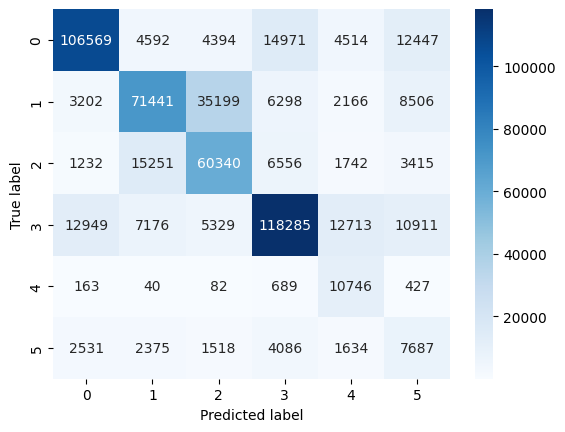

In [ ]:
for i in range (len(true_labels_val)):
    true_labels_val[i] = true_labels_val[i].numpy()
for i in range (len(predicted_labels_val)):
    predicted_labels_val[i] = predicted_labels_val[i].numpy()

true_labels_val = np.array(true_labels_val)
true_labels_val = np.squeeze(true_labels_val)


predicted_labels_val = np.array(predicted_labels_val).flatten()
true_labels_val = np.array(true_labels_val).flatten()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# print accuracy
print("Accuracy:", accuracy_score(true_labels_val, predicted_labels_val))
print("Precision:", precision_score(true_labels_val, predicted_labels_val, average='weighted'))
print("Recall:", recall_score(true_labels_val, predicted_labels_val, average='weighted'))
print("F1:", f1_score(true_labels_val, predicted_labels_val, average='weighted'))

# print confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels_val, predicted_labels_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')


# print classification report
from sklearn.metrics import classification_report

print(classification_report(true_labels_val, predicted_labels_val))

## Test Set

In [ ]:
# test
test_loss, predicted_labels_test, true_labels_test = test(model, val_dataloader, device=device)

Test Loss: 0.8652


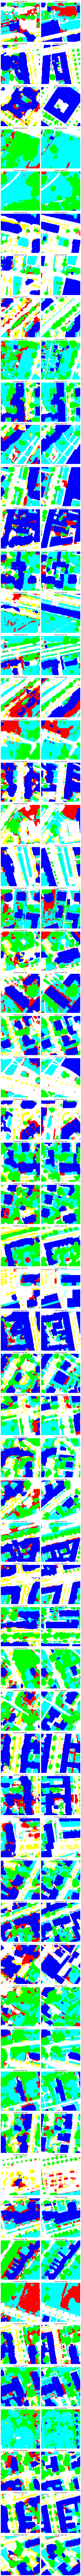

In [ ]:
import matplotlib.pyplot as plt


# test
predicted_labels_test_rgb = [dataset.revert_image(label) for label in predicted_labels_test]
true_labels_test_rgb = [dataset.revert_image(label[0]) for label in true_labels_test]

if len(predicted_labels_test_rgb) == 1:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].imshow(predicted_labels_test_rgb[0].permute(1,2,0))
    axes[0].set_title("Predicted Label test")
    axes[0].axis('off')

    original_img = dataset.revert_image(dataset.labels[0].reshape(PATCH_SIDE, PATCH_SIDE)).permute(1,2,0)
    axes[1].imshow(original_img)
    axes[1].set_title("Original Label")
    axes[1].axis('off')
else:
    fig, axes = plt.subplots(nrows=len(predicted_labels_test_rgb), ncols=2, figsize=(10, len(predicted_labels_test_rgb)*5))

    for i in range(len(predicted_labels_test_rgb)):
        axes[i, 0].imshow(predicted_labels_test_rgb[i].permute(1,2,0))
        axes[i, 0].set_title("Predicted Label Test")
        axes[i, 0].axis('off')

        # original_img = dataset.revert_image(true_labels_train_rgb[i].permute(1,2,0)
        axes[i, 1].imshow(true_labels_test_rgb[i].permute(1,2,0))
        # axes[i, 1].imshow(original_img)
        axes[i, 1].set_title("Original Label Test")
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

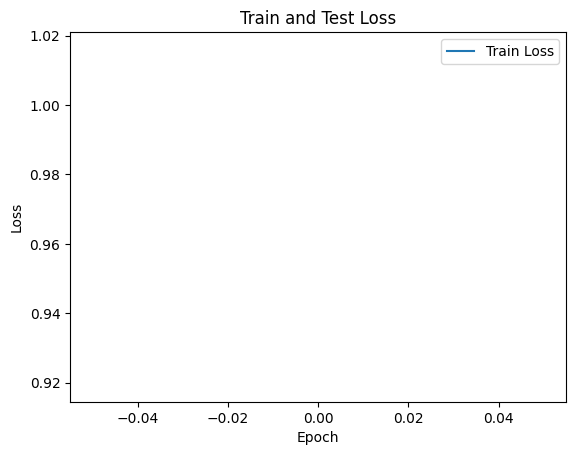

In [ ]:
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

In [ ]:
# print(np.shape(predicted_labels_test))
# print(np.shape(true_labels))
for i in range (len(true_labels_test)):
    true_labels_test[i] = true_labels_test[i].numpy()
for i in range (len(predicted_labels_test)):
    predicted_labels_test[i] = predicted_labels_test[i].numpy()

true_labels_test = np.array(true_labels_test)
true_labels_test = np.squeeze(true_labels_test)
print(np.shape(true_labels_test))



import numpy as np

# Convert the lists to numpy arrays
predicted_labels_test = np.array(predicted_labels_test).flatten()
true_labels_test = np.array(true_labels_test).flatten()

# Count the occurrences of each class label
predicted_counts = np.bincount(predicted_labels_test)
true_counts = np.bincount(true_labels_test)

# Print the counts
for label, count in enumerate(predicted_counts):
    print(f"Predicted label {label}: {count} occurrences")

for label, count in enumerate(true_counts):
    print(f"True label {label}: {count} occurrences")

(61, 96, 96)
Predicted label 0: 126646 occurrences
Predicted label 1: 100875 occurrences
Predicted label 2: 106862 occurrences
Predicted label 3: 150885 occurrences
Predicted label 4: 33515 occurrences
Predicted label 5: 43393 occurrences
True label 0: 147487 occurrences
True label 1: 126812 occurrences
True label 2: 88536 occurrences
True label 3: 167363 occurrences
True label 4: 12147 occurrences
True label 5: 19831 occurrences


Accuracy: 0.6671718465391621
Precision: 0.7160012734991901
Recall: 0.6671718465391621
F1: 0.6828466191878486
              precision    recall  f1-score   support

           0       0.84      0.72      0.78    147487
           1       0.71      0.56      0.63    126812
           2       0.56      0.68      0.62     88536
           3       0.78      0.71      0.74    167363
           4       0.32      0.88      0.47     12147
           5       0.18      0.39      0.24     19831

    accuracy                           0.67    562176
   macro avg       0.57      0.66      0.58    562176
weighted avg       0.72      0.67      0.68    562176



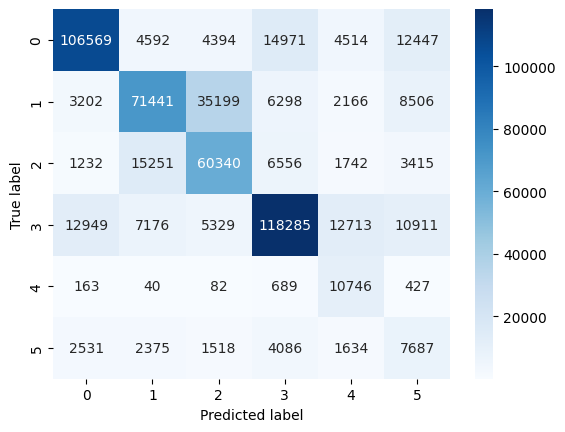

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels_test = np.array(true_labels_test)
true_labels_test = np.squeeze(true_labels_test)

# print accuracy
print("Accuracy:", accuracy_score(true_labels_test, predicted_labels_test, ))
print("Precision:", precision_score(true_labels_test, predicted_labels_test, average='weighted'))
print("Recall:", recall_score(true_labels_test, predicted_labels_test, average='weighted'))
print("F1:", f1_score(true_labels_test, predicted_labels_test, average='weighted'))

# print confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels_test, predicted_labels_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')


# print classification report
from sklearn.metrics import classification_report

print(classification_report(true_labels_test, predicted_labels_test))


